### Dependencies

In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns

### List of Classes

In [13]:
print(os.listdir('dataset_images/train'))


['score0', 'score1', 'score10', 'score2', 'score3', 'score4', 'score5', 'score6', 'score7', 'score8', 'score9']


### Dataset Paths

In [14]:
training_dataset_path = 'dataset_images/train'
test_dataset_path = 'dataset_images/test'

### Mean and Standard Deviation of image pixel values

In [15]:
def get_mean_and_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)

        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

        total_images_count += image_count_in_a_batch
    
    mean /= total_images_count
    std /= total_images_count

    return mean, std

### Image transforms to input into model as Tensors

In [16]:
mean = [0.8824, 0.8603, 0.8445]
std = [0.2786, 0.2946, 0.3126]

training_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))

])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

### Train and test dataset composition

In [17]:
train_dataset = torchvision.datasets.ImageFolder(root = training_dataset_path, transform = training_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = test_dataset_path, transform=test_transforms)

In [18]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size= 64, shuffle = False)

### Display transformed images

In [19]:
def show_transformed_images(dataset, indices = None ):
    """ Utility function to display image transformations input into nn"""

    if indices is None:
        indices = random.sample(range(len(dataset)), 6)

    images = [dataset[i][0] for i in indices]
    labels = [dataset[i][1] for i in indices]

    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11, 11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis('on')
    plt.show()
    print('labels:', labels)

# show_transformed_images(train_dataset)

### CNN Model architecture

In [20]:

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=11):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 56 * 56, 256)  # Assuming input image size is 224x224
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        # Flatten the input for fully connected layers
        x = x.view(-1, 32 * 56 * 56)
        # Fully connected layers with ReLU activation
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


### Use gpu if available

In [21]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Define Hyper-Parameters

In [22]:
# Initialize the model
model = SimpleCNN(num_classes=11).to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer  
optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training loop
num_epochs = 80
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total * 100

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

Epoch [1/80], Train Loss: 1.8361, Train Accuracy: 30.84%
Epoch [2/80], Train Loss: 1.5323, Train Accuracy: 38.18%
Epoch [3/80], Train Loss: 1.3779, Train Accuracy: 45.53%
Epoch [4/80], Train Loss: 1.2225, Train Accuracy: 51.27%
Epoch [5/80], Train Loss: 1.0852, Train Accuracy: 56.42%
Epoch [6/80], Train Loss: 0.9740, Train Accuracy: 61.47%
Epoch [7/80], Train Loss: 0.8881, Train Accuracy: 64.74%
Epoch [8/80], Train Loss: 0.8172, Train Accuracy: 67.49%
Epoch [9/80], Train Loss: 0.7701, Train Accuracy: 69.00%
Epoch [10/80], Train Loss: 0.7034, Train Accuracy: 70.89%
Epoch [11/80], Train Loss: 0.6754, Train Accuracy: 72.08%
Epoch [12/80], Train Loss: 0.6302, Train Accuracy: 73.70%
Epoch [13/80], Train Loss: 0.6116, Train Accuracy: 74.51%
Epoch [14/80], Train Loss: 0.5888, Train Accuracy: 75.37%
Epoch [15/80], Train Loss: 0.5634, Train Accuracy: 75.74%
Epoch [16/80], Train Loss: 0.5456, Train Accuracy: 76.57%
Epoch [17/80], Train Loss: 0.5284, Train Accuracy: 76.69%
Epoch [18/80], Train Lo

### Save model to file

In [29]:
# Save the trained model
# torch.save(model.state_dict(), "simple_cnn_model.pth")

### Plot loss and accuracy

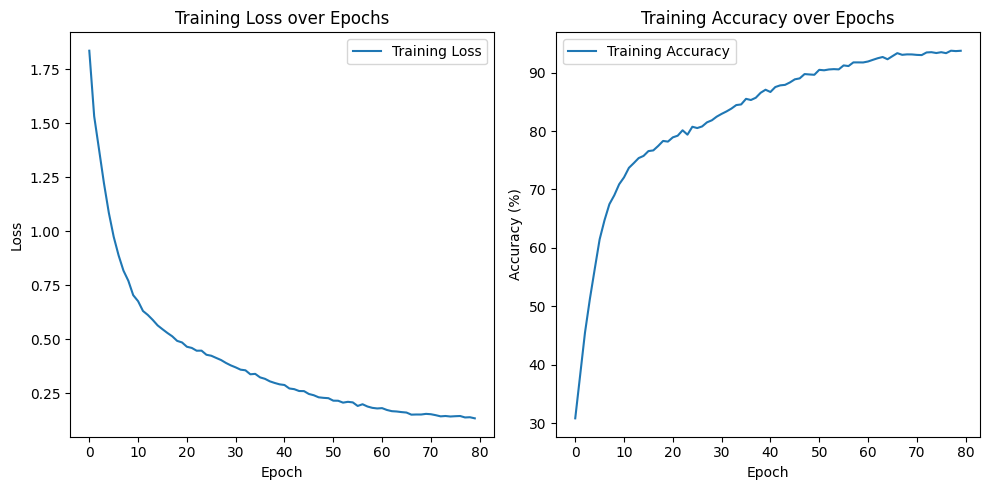

[1.836125078734818, 1.532341562784635, 1.3778677845334673, 1.222491383969367, 1.0852140584192076, 0.9739534150470387, 0.8881229829121303, 0.8172208154118145, 0.7701031944968484, 0.7034008738461074, 0.6754343299182145, 0.6301865865300585, 0.6116354086182334, 0.5888478516281902, 0.5634103071439517, 0.545552047607782, 0.5284000674744586, 0.5127654608104613, 0.49167948315193605, 0.4843791631551889, 0.46443720797558763, 0.4589401869090287, 0.4460730140025799, 0.446358389266721, 0.42731311333763017, 0.4227508831691075, 0.4126850067527144, 0.4028839500217171, 0.38943288688893085, 0.37804303104644055, 0.36884046038547597, 0.3582558833010547, 0.35527618719147636, 0.33683133542120874, 0.3387200041459157, 0.3224647391092527, 0.31577263668283717, 0.3041027015322572, 0.2965876709122758, 0.2901943457293344, 0.28713980921498544, 0.2710588412372382, 0.2678482075567012, 0.2593131971942795, 0.25881240146977086, 0.24555483637573003, 0.2397430839238467, 0.2301424603674795, 0.22763552923094144, 0.226087096

In [27]:
# Plot the training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
print(train_losses)

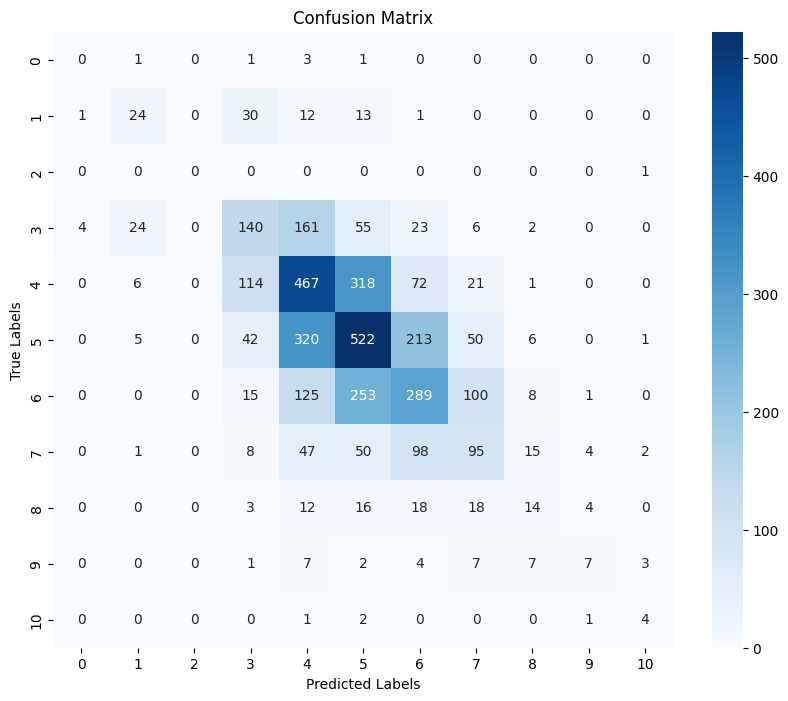

In [28]:
model.eval()
true_labels = []
predicted_labels = []

for images, labels in test_loader:
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(preds.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()